## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [267]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [268]:
# Data Normalization

loader = DataLoader(train_dataset, batch_size=len(train_dataset))
data = next(iter(loader))

x = data[0].flatten(0,1).transpose(0,1)[0]
y = data[0].flatten(0,1).transpose(0,1)[1]
xMean, xStd, yMean, yStd = x.mean(), x.std(), y.mean(), y.std()

In [269]:
batch_sz = 64  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Data Visualization

### Heatmap of car routes

Heatmap of car routes in austin


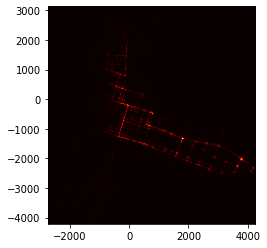

Heatmap of car routes in miami


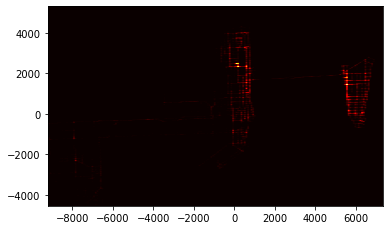

Heatmap of car routes in pittsburgh


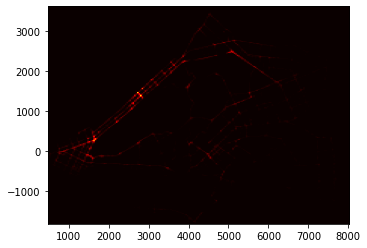

Heatmap of car routes in dearborn


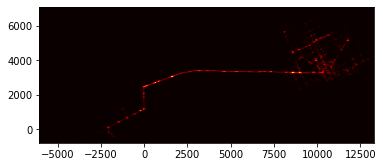

Heatmap of car routes in washington-dc


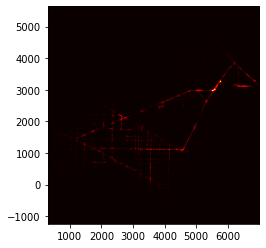

Heatmap of car routes in palo-alto


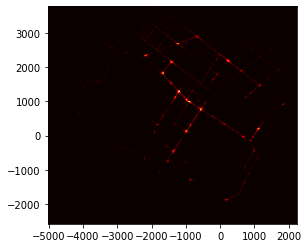

In [5]:
for n in cities:
    x = []
    y = []

    inp, out = get_city_trajectories(city=n)
    for i in inp:
        x += list(i.T[0])
        y += list(i.T[1])
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    print('Heatmap of car routes in %s' %(n))
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap = 'hot')
    plt.show()
        


## Sample a batch of data and visualize 

In [6]:
def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
    for i_batch, sample_batch in enumerate(train_loader):
        show_sample_batch(sample_batch)
        break

## Feature Engineering

## LSTM to FC Layer Model w/ no sequence length modifying

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [8]:
# Parameter initialization

hidden_size = 128
epochs = 30
lr = 0.001
feature_size = 2
inp_seq_len = 1
num_layers = 2
out_seq_len = 60

In [9]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(feature_size, hidden_size, num_layers, batch_first = True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
#         x -> (batch_size, seq_len, input_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, feature_size)
    
    def forward(self,x):
        h0 = torch.zeros(num_layers, x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.shape[0], self.hidden_size).to(device)
             
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(out1, _)
        

#         out = out[:,-1,:]
        fc1 = F.relu(self.fc1(out2))
        out = self.fc2(fc1)
        return out

In [10]:
lstm = LSTM(feature_size, hidden_size, num_layers).to(device)

adam = optim.Adam(lstm.parameters(), lr = lr)

lossFunction = nn.MSELoss().to(device)

### Training methods

In [11]:
# TRAINING WITH DATA IMPUTING

from sklearn.preprocessing import MinMaxScaler

adamLosses = []
 # Initialize zero grad

for n in range(epochs):
    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        lstm.zero_grad()

        inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd])) # Normalization
        
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 
            
        splitted = torch.split(inp, 1, dim=1) # Split to get the last 10 inputs individually
            
        for i in range(1,11):
            inp = torch.cat((inp, splitted[-i]),1) # Impute with last 10 inputs
        
        
        outputs = lstm(inp)
        loss = lossFunction(outputs, out)
        adamLosses.append(loss)
        loss.backward()
        adam.step()

188it [00:02, 72.62it/s]
188it [00:02, 70.62it/s]
188it [00:02, 85.73it/s]
188it [00:02, 81.94it/s]
188it [00:02, 76.46it/s]
188it [00:02, 73.57it/s]
188it [00:02, 80.31it/s]
188it [00:02, 79.62it/s]
188it [00:02, 89.58it/s]
188it [00:02, 74.50it/s]
188it [00:02, 79.48it/s]
188it [00:02, 84.59it/s]
188it [00:02, 83.39it/s]
188it [00:02, 76.94it/s]
188it [00:02, 77.23it/s]
188it [00:02, 77.54it/s]
188it [00:02, 74.37it/s]
188it [00:02, 78.44it/s]
188it [00:02, 84.27it/s]
188it [00:02, 72.42it/s]
188it [00:02, 86.26it/s]
188it [00:01, 94.51it/s] 
188it [00:02, 83.52it/s]
188it [00:02, 81.47it/s]
188it [00:02, 79.40it/s]
188it [00:02, 79.10it/s]
188it [00:02, 84.90it/s]
188it [00:02, 82.99it/s]
188it [00:02, 84.56it/s]
188it [00:02, 86.74it/s]


In [12]:
adamLosses = [round(float(x),3) for x in adamLosses]

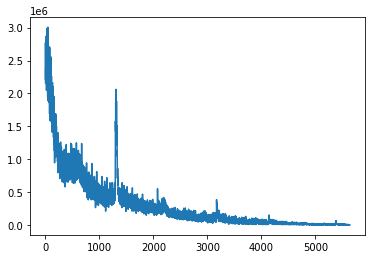

In [13]:
# Loss plot with Adam optimizer

plt.plot(range(len(adamLosses)), adamLosses)
plt.show()

In [14]:
out[0][0]

tensor([-1201.8894,  1265.0101], device='cuda:0')

In [15]:
outputs[0][0]

tensor([-1229.2593,  1253.8906], device='cuda:0', grad_fn=<SelectBackward>)

In [16]:
adamLosses[-6:]

[6027.523, 6996.873, 6369.143, 6066.353, 7466.231, 3817.378]

In [17]:
# TESTING

test_dataset  = ArgoverseDataset(city = city, split = 'train')
test_loader = DataLoader(test_dataset,batch_size=batch_sz)

test_loss = []

for i_batch, sample_batch in tqdm(enumerate(test_loader)):
        inp, out = sample_batch
        inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd]))
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 

        splitted = torch.split(inp, 1, dim=1) # Split to get the last 10 inputs individually
            
        for i in range(1,11):
            inp = torch.cat((inp, splitted[-i]),1) # Impute with last 10 inputs
        
        outputs = lstm(inp)
        
        loss = lossFunction(outputs, out)
        test_loss.append(loss)
        

188it [00:01, 123.64it/s]


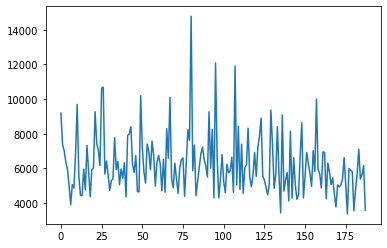

In [18]:
testLosses = [round(float(x),3) for x in test_loss]
plt.plot(range(len(testLosses)), testLosses)
plt.show()

In [19]:
testLosses

[9192.403,
 7366.633,
 7017.876,
 6361.774,
 5958.418,
 5014.163,
 3896.527,
 5053.782,
 4857.629,
 6876.753,
 9692.744,
 5575.681,
 4424.936,
 4419.745,
 5951.906,
 4752.377,
 7322.466,
 5789.823,
 4353.577,
 5928.107,
 6018.027,
 9267.023,
 7428.519,
 7036.903,
 6148.179,
 10639.352,
 10689.235,
 5663.723,
 6416.035,
 5624.484,
 4722.324,
 5290.977,
 5390.198,
 7779.613,
 5914.143,
 6399.652,
 5049.88,
 5962.954,
 5421.457,
 6319.055,
 4347.155,
 7894.363,
 7984.101,
 8398.11,
 6218.924,
 5760.519,
 6731.146,
 4657.606,
 4629.789,
 10195.09,
 7209.995,
 5788.506,
 5142.782,
 7405.042,
 6977.424,
 5914.787,
 7561.735,
 6737.525,
 4965.067,
 6333.836,
 6746.818,
 6251.878,
 4695.357,
 6522.826,
 4614.741,
 8289.849,
 6580.288,
 10095.467,
 5391.846,
 4870.482,
 6299.421,
 5380.386,
 4551.965,
 6000.089,
 6491.654,
 6596.612,
 4382.773,
 6295.531,
 8221.186,
 7617.448,
 14788.705,
 5852.876,
 7337.718,
 4410.14,
 5244.174,
 6059.384,
 6844.238,
 7219.939,
 6503.013,
 6146.985,
 5495.938

In [154]:
torch.cuda.empty_cache()

## LSTM to FC w/ sequence length modifying

In [279]:
# Parameter initialization

hidden_size = 256
epochs = 100
lr = 0.01
num_layers = 2
out_seq_len = 60
inp_seq_len = 50

In [280]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(inp_seq_len, hidden_size, num_layers, batch_first = True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
#         x -> (batch_size, seq_len, input_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_seq_len)
    
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
             
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(out1, _)
        
        fc1 = self.fc1(out2)
        out = self.fc2(fc1)
        return out.transpose(1,2)

In [281]:
lstm = LSTM(hidden_size, out_seq_len, num_layers).to(device)
adam = optim.Adam(lstm.parameters(), lr = lr)
lossFunction = nn.MSELoss().to(device)

In [282]:
# Trianing with sequence modifying

adamLosses = []

for n in range(epochs):
    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        lstm.zero_grad()
            
        inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd])) # Normalization
            
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 
        outputs = lstm(inp.transpose(1,2))
        
        loss = lossFunction(outputs, out)
        adamLosses.append(loss)
        loss.backward()
        adam.step()

188it [00:01, 165.89it/s]
188it [00:01, 166.48it/s]
188it [00:01, 142.14it/s]
188it [00:01, 154.39it/s]
188it [00:01, 153.00it/s]
188it [00:01, 178.91it/s]
188it [00:01, 180.61it/s]
188it [00:01, 158.48it/s]
188it [00:01, 163.74it/s]
188it [00:01, 152.22it/s]
188it [00:01, 174.35it/s]
188it [00:01, 171.50it/s]
188it [00:01, 182.17it/s]
188it [00:01, 148.93it/s]
188it [00:01, 146.12it/s]
188it [00:01, 164.32it/s]
188it [00:01, 183.10it/s]
188it [00:01, 158.55it/s]
188it [00:01, 167.60it/s]
188it [00:01, 160.59it/s]
188it [00:01, 164.80it/s]
188it [00:01, 167.72it/s]
188it [00:01, 144.20it/s]
188it [00:01, 132.91it/s]
188it [00:01, 130.03it/s]
188it [00:01, 128.82it/s]
188it [00:01, 119.30it/s]
188it [00:01, 130.09it/s]
188it [00:01, 146.10it/s]
188it [00:01, 146.65it/s]
188it [00:01, 149.55it/s]
188it [00:01, 158.58it/s]
188it [00:01, 152.33it/s]
188it [00:01, 142.52it/s]
188it [00:01, 149.35it/s]
188it [00:01, 159.43it/s]
188it [00:01, 142.98it/s]
188it [00:01, 142.64it/s]
188it [00:01

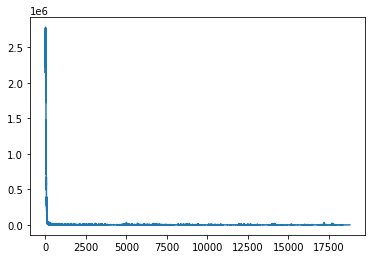

In [283]:
# Loss plot with Adam optimizer
adamLosses = [round(float(x),3) for x in adamLosses]
plt.plot(range(len(adamLosses)), adamLosses)
plt.show()

In [284]:
adamLosses[-6:]

[639.547, 533.263, 773.32, 415.454, 576.576, 687.271]

In [288]:
test_dataset  = ArgoverseDataset(city = city, split = 'train')
test_loader = DataLoader(test_dataset,batch_size=batch_sz)

test_loss = []

for i_batch, sample_batch in tqdm(enumerate(test_loader)):
    inp, out = sample_batch
    inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd])) # Normalization

    inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 
    outputs = lstm(inp.transpose(1,2))

    loss = lossFunction(outputs, out)
    test_loss.append(loss)

188it [00:00, 508.92it/s]


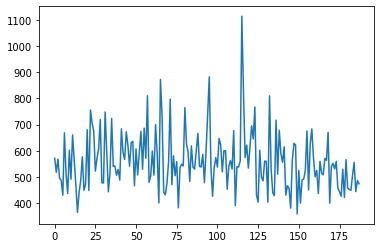

In [289]:
testLosses = [round(float(x),3) for x in test_loss]
plt.plot(range(len(testLosses)), testLosses)
plt.show()

In [290]:
np.mean(testLosses)

558.0661968085107

In [ ]:
i = inp[0].transpose(0,1).cpu().detach().numpy()
i[0] = i[0]*float(xStd)+float(xMean)
i[1] = i[1]*float(yStd)+float(yMean)

o = outputs[0].transpose(0,1).cpu().detach().numpy()
a = out[0].transpose(0,1).cpu().detach().numpy()

plt.scatter(i[0], i[1], label = 'Input')
plt.scatter(o[0], o[1], label = 'Model Output')
plt.scatter(a[0], a[1], label = 'Actual')
plt.legend(loc = 'upper right')
plt.show()

### Seperating X any Y's

In [ ]:


hidden_size = 128
epochs = 11
batch_size = batch_sz
lr = 0.01
feature_size = 2
num_layers = 1
out_seq_len = 60

In [ ]:
# Seperating X and Y

lstmX = LSTM(hidden_size, out_seq_len, num_layers).to(device)
lstmY = LSTM(hidden_size, out_seq_len, num_layers).to(device)

adamX = optim.Adam(lstmX.parameters(), lr = lr)
adamY = optim.Adam(lstmY.parameters(), lr = lr)

lossFunctionX = nn.MSELoss().to(device)
lossFunctionY = nn.MSELoss().to(device)

In [ ]:
lossesX = []
lossesY = []

for n in range(epochs):
    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        lstmX.zero_grad()
        lstmY.zero_grad()
        inp, out = sample_batch
        out = out.to(device).to(torch.float32) 
        inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd])) # Normalization

            
        inpTemp = inp.transpose(1,2).split(1, dim = 1) # 0 denotes X coors 1 denotes Y coors
        outTemp = out.transpose(1,2).split(1, dim = 1)
        
        inpX = inpTemp[0]
        inpY = inpTemp[1]
        
            
        for n in range(len(inpY)):
            scaler = MinMaxScaler()
            scaler.fit(inpY[n])
            inpY[n] = torch.tensor(scaler.transform(inpY[n])) # MIN MAX SCALING for Y
            
        inpX = inpX.to(device).to(torch.float32)
        inpY = inpY.to(device).to(torch.float32)
        
        outX = outTemp[0].transpose(1,2)
        outY = outTemp[1].transpose(1,2)
        
        outputsX = lstmX(inpX)
        outputsY = lstmY(inpY)
        
        lossX = lossFunctionX(outputsX, outX)
        lossY = lossFunctionY(outputsY, outY)
        
        lossesX.append(lossX)
        lossesY.append(lossY)
        lossX.backward()
        lossY.backward()
        
        adamX.step()
        adamY.step()

In [ ]:

plt.plot(range(len(lossesX)), [round(float(x),3) for x in lossesX])

In [ ]:

plt.plot(range(len(lossesY)), [round(float(x),3) for x in lossesY])

In [ ]:
np.mean([int(torch.tensor(lossesX).mean()), int(torch.tensor(lossesY).mean())])

In [ ]:
torch.cuda.empty_cache()

## 1D conv with LSTM

In [ ]:
input_size = 2
hidden_size = 128
output_size = 60
batch_size = batch_sz
n_layers = 2
seq_len = 50
epochs = 100

In [ ]:
class Conv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Conv, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.MaxPool1d(4)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.MaxPool1d(5)
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.shape[0]
        

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs).to(device)
        p = self.p1(c).to(device)
        c = self.c2(p).to(device)
        p = self.p2(c).to(device)
        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1).to(device)
        
        p = F.relu(p).to(device)
        output, hidden = self.lstm1(p, hidden)
        output, hidden = self.lstm2(output, hidden)
        conv_seq_len = output.shape[0]
        output = output.view(conv_seq_len * inputs.shape[0], self.hidden_size).to(device) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
#         output = torch.tanh(self.out(output))
        output = self.out(output).to(device)
        output = output.view( -1, self.output_size, conv_seq_len).to(device)
        return output, hidden

In [ ]:
conv = Conv(input_size, hidden_size, output_size, n_layers=n_layers).to(device)
optimizer = optim.Adam(conv.parameters(), lr = 0.01)
lossFunction = nn.MSELoss().to(torch.float32)

In [ ]:
losses = []


for n in range(epochs):

    for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        conv.zero_grad()
        inp, out = sample_batch
        
        inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd])) # Normalization
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 

        outputs, hidden = conv(inp.transpose(1,2), None)
        
        loss = lossFunction(outputs, out)
        losses.append(loss)
        loss.backward()
        optimizer.step()


In [ ]:
losses = [float(x) for x in losses]

In [ ]:
plt.plot(range(len(losses)), losses)

In [ ]:
out[0][0]

In [ ]:
outputs[0][0]

In [ ]:
losses[-6:]

In [ ]:
# TESTING


for i_batch, sample_batch in tqdm(enumerate(train_loader)):
        inp, out = sample_batch
        inp = torch.div(torch.sub(inp, torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd])) # Normalization
            
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 
        outputs = lstm(inp.transpose(1,2))
        
        loss = lossFunction(outputs, out)
        test_loss.append(loss)
        
testLosses = [round(float(x),3) for x in test_loss]
plt.plot(range(len(testLosses)), testLosses)

In [ ]:
testLosses[-6:]

## Combining all cities

In [343]:
# Concating all train inputs and shuffling

In [396]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [397]:
cityOneHot = torch.tensor(np.eye(len(cities))) # One Hot encoding for cities

In [398]:
allTrainInp = torch.empty(0)
allTrainOut = torch.empty(0)

for n in range(len(cities)):
    train_data  = ArgoverseDataset(city = cities[n], split = 'train')
    loader = DataLoader(train_data, batch_size=len(train_data))
    data = next(iter(loader))
    
    x = data[0].flatten(0,1).transpose(0,1)[0]
    y = data[0].flatten(0,1).transpose(0,1)[1]
    xMean, xStd, yMean, yStd = x.mean(), x.std(), y.mean(), y.std()
    
    inp = torch.div(torch.sub(data[0], torch.tensor([xMean, yMean])), torch.tensor([xStd, yStd]))
    out = data[1]
    
    inp = torch.cat((inp, cityOneHot[n].repeat(inp.shape[0], 50, 1)), 2)
    
    if allTrainInp.shape[0] == 0:
        allTrainInp = inp
    if allTrainOut.shape[0] == 0:
        allTrainOut = out
    else:
        allTrainInp = torch.cat((allTrainInp, inp), 0)
        allTrainOut = torch.cat((allTrainOut, out), 0)
    


In [399]:
allTrainOut.shape

torch.Size([203816, 60, 2])

In [400]:
def shufflerow(inpTensor, outTensor, axis):
    row_permInp = torch.rand(inpTensor.shape[:axis+1]).argsort(axis)  # get permutation indices
    row_permOut = torch.tensor(row_permInp)
    print(row_permInp)
    print(row_permOut)
    for _ in range(inpTensor.ndim-axis-1): 
        row_permInp.unsqueeze_(-1)
    row_permInp = row_permInp.repeat(*[1 for _ in range(axis+1)], *(inpTensor.shape[axis+1:]))  # reformat this for the gather operation
    
    for _ in range(outTensor.ndim-axis-1): 
        row_permOut.unsqueeze_(-1)
    row_permOut = row_permOut.repeat(*[1 for _ in range(axis+1)], *(outTensor.shape[axis+1:]))
    
    
    return (inpTensor.gather(axis, row_permInp), outTensor.gather(axis, row_permOut))

In [401]:
allTrainInp, allTrainOut = shufflerow(allTrainInp, allTrainOut, 0)

/tmp/ipykernel_2198/2297281998.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row_permOut = torch.tensor(row_permInp)


tensor([104796,  71739, 196762,  ..., 190806, 158350,  57069])
tensor([104796,  71739, 196762,  ..., 190806, 158350,  57069])


In [402]:
# Parameter initialization

hidden_size = 256
epochs = 100
lr = 0.01
num_layers = 2
out_seq_len = 60
inp_seq_len = 50

In [403]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(inp_seq_len, hidden_size, num_layers, batch_first = True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
#         x -> (batch_size, seq_len, input_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_seq_len)
    
    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
             
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(out1, _)
        
        fc1 = self.fc1(out2)
        out = self.fc2(fc1)
        return out.transpose(1,2)

In [404]:
lstm = LSTM(hidden_size, out_seq_len, num_layers).to(device)
adam = optim.Adam(lstm.parameters(), lr = lr)
lossFunction = nn.MSELoss().to(device)

In [405]:
trainLosses = []

for n in range(epochs):
    prev = 0
    for i in range(0, allTrainInp.shape[0], batch_sz):
        while i <= allTrainInp.shape[0]:
            inp, out = allTrainInp[prev-i: i, :, :], allTrainOut[prev-i: i, :, :]
            lstm.zero_grad()

            inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32) 
            outputs = lstm(inp.transpose(1,2))

            loss = lossFunction(outputs, out)
            adamLosses.append(loss)
            loss.backward()
            adam.step()
            prev += i

RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.